In [4]:
import numpy as np
import json
from scipy.optimize import least_squares
from scipy.interpolate import CubicSpline
import dfbgn

In [2]:
%run PES_incremental_exp.ipynb

StopIteration: 

In [6]:
list_data = np.load('data/hxoy_data_corr_071021.npy', allow_pickle=True) #reload
list_data = list_data[()]
print(len(list_data))

39


general f_obj, RMSE: $\sqrt{\frac{1}{n}\sum^n_{i=1}(V_{pred} - V_{ab initio})^2}$

In [7]:
## useful functions

def RMSE(Y_pred, Y):
    #error between Y prediction and Y actual
    error = 0
    n = len(Y)
    for i in range(n):
        diff = (Y[i]-Y_pred[i])**2
        error += diff
    return np.sqrt(error/n)

polynomial fit f_obj, minimize: $\sum_{i=1}^n |p(R_i) - V_i|^2$

In [54]:
'''
The models and objective functions
'''

np.random.seed(13) #reprodicuibility

## First proposed model:
f_morse_pot = lambda r,a: np.exp(-r/a)

def f_poly(x, c): #general polynomial, evaluated at x by horner's scheme
    y = c[-1]
    for i in range(len(c)-2, -1, -1):
        y = y*x + c[i]
    return y
    
def f_monomial_diatomic_pot(r, coeffs, morse=False): #monomial pot - permutationally invariant functional 
    #r := r_i, the ith distance
    #coeffs := the coefficients, in increasing order of polynomial (0,1,2,...)
    #evaluate the polynomial by horner's scheme:
    y = r
    v = coeffs[-1]
    for i in range(len(coeffs)-2, -1, -1):
        #i := power of the polynomial
        if morse and i > 0: #exclude the constant for morse
            y = f_morse_pot(r,i)
        v = v*y + coeffs[i]
    return v

def f_poly_obj(R, V, coeffs, F, poly_par): #least squares for all polynomials 
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    M = poly_par["M"]; morse = poly_par["morse"]
    ssum = 0
    length = len(R)
    for i in range(length):
        p = F(R[i], coeffs, morse)
        diff = (p-V[i])**2
        ssum += diff
    return ssum

def f_poly_obj2(C, *args): #least squares for all polynomials 
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    F = args[0]
    R = args[1]
    V = args[2]
    poly_par = args[-1]
    M = poly_par["M"]; morse = poly_par["morse"]
    ssum = 0
    length = len(R)
    for i in range(length):
        p = F(R[i], C, morse)
        diff = (p-V[i])**2
        ssum += diff
    return ssum

def f_poly_res(C, *args): #residuals function
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    F = args[0]
    R = args[1]
    V = args[2]
    poly_par = args[-1]
    M = poly_par["M"]; morse = poly_par["morse"]
    length = len(R)
    residuals = np.zeros(length)
    for i in range(length):
        p = F(R[i], C, morse)
        residuals[i] = (p-V[i])**2
    return residuals

def f_poly_res2(C, *args): #residuals function
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    F = args[0]
    R = args[1]
    V = args[2]
    poly_par = args[-1]
    M = poly_par["M"]; morse = poly_par["morse"]
    length = len(R)
    residuals = np.zeros(length)
    for i in range(length):
        p = F(R[i], C, morse)
        residuals[i] = p-V[i]
    return residuals

## second proposed model:
def f_diatomic_pot_lr(C, *args):
    #C = fitted coefficients, [0:len(C)] is the polynomials' coefficients c_i, [-1] is the nonlinear decaying exp coeff r_0
    ##uses *args because dfbgn doesnt accept **kwargs
    #args[0] := r, the internuclear distance
    #args[1] := Z = (Z_1, Z_2), the tuple of nuclear charges
    #M, the max polynomial degree (= len(C)-2)
    r0 = C[-1]
    r = args[0]
    Z = args[1]
    M = len(C)-2
    y = np.exp(-r/r0)
    #V = (Z[0]*Z[1])/r + C[0]
    V = (Z[0]*Z[1] + C[0])/r*(1+C[1]*(r**6))
    
    poly_V = C[-2]
    #for i in range(M-1, 1, -1): 
    for i in range(M-1, 2, -1):
        poly_V = poly_V*y + C[i]
        #print(i, poly_V, C[i])
    '''
    #non horner version:
    poly_V = 0
    #for i in range(2, M):
    for i in range(3, M): 
        poly_V += C[i]*(y**(i-3))
        #print(i, poly_V)
        #poly_V = poly_V*y + C[i-2]
    '''
    #poly_V *= ((1-y)/(r**3 + C[1]))**2
    poly_V *= ((1-y)/(r**3 + C[2]))**2
    V += poly_V
    return V

def f_obj_diatomic_pot_res(C, *args):
    #the objective function to be fitted, in residuals form, for least squares
    #C = coefficients to be fitted
    #args[0] = function to be fitted, returns predicted data, Y_pred
    #args[1] = vector of actual data, Y
    #args[2:] = args of args[0]
    F = args[0]
    V = args[1] #the energy vector
    R = args[2] #the distance vector
    Z = args[3] #nuclear charges of two atoms
    #error = 0 
    n = len(V)
    residuals = np.zeros(n)
    for i in range(n):
        v_pred = F(C, R[i], Z)
        residuals[i] = V[i]-v_pred
        #residuals[i] = (V[i]-v_pred)**2
        #error += diff
    return residuals


In [52]:
#unit test
np.random.seed(13)
np.random.rand(5)

C = [0,1,2,3,4,4,5,5,6,6,7,8]*6
R = 2
v = f_monomial_diatomic_pot(R, C)
v_ = f_poly(R, C)
#print(v, v_)

In [53]:
Z = (1,8)
r = 2
f_diatomic_pot_lr(C, r, Z)

260.0094280193822

In [55]:
f_diatomic_pot_lr(C, r, Z)

260.00942801956427

### train on OH+ data of Xavier

In [13]:
mol = "OH+"
qidxs = query_one_var_indices(mol, "mol", list_data)
#test on idx 1, train on idx 4:
idx = 4
R = list_data[qidxs[idx]]["R"]
V = list_data[qidxs[idx]]["V"]

In [14]:
#train using polynomial fit
M = 13 #max degree of polynomial
poly_par = {"M": M, "morse" : False}
#c = np.zeros(M)
#f = f_poly_obj(R, V, c, f_monomial_diatomic_pot, poly_par)
#print(f)
#test using numpy's polyfit:
c = np.polyfit(R, V, M) #automatic fit by numpy
e = f_poly_obj(R, V, c[::-1], f_monomial_diatomic_pot, poly_par)
print("training error = ",e)
p = np.poly1d(c)
p_V = p(R)

training error =  5.382597244179081e-05


### test on OH+ data of Werner

In [30]:
idx = 1
R_test = list_data[qidxs[idx]]["R"]
V_test = list_data[qidxs[idx]]["V"]
p_V_test = p(R_test)
e = f_poly_obj(R_test, V_test, c[::-1], f_monomial_diatomic_pot, poly_par)
print("testing error = ",e)
print("testing RMSE = ",RMSE(V_test, p_V_test))

testing error =  2.9877720569352594e-05
testing RMSE =  0.005466051643494836


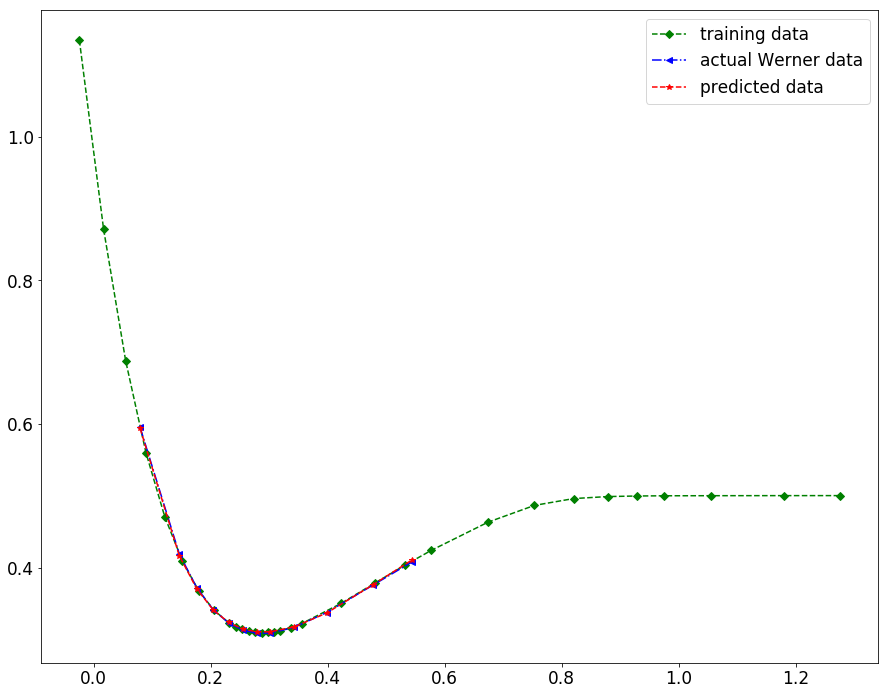

In [16]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(15, 12))
plt.plot(np.log10(R), V, "g--D")
plt.plot(np.log10(R_test), V_test, "b-.<")
plt.plot(np.log10(R_test), p_V_test, "r--*")
plt.legend(["training data","actual Werner data", "predicted data"])

### Cubic spline

training RMSE = 0.0
testing RMSE = 0.0035166731030738677


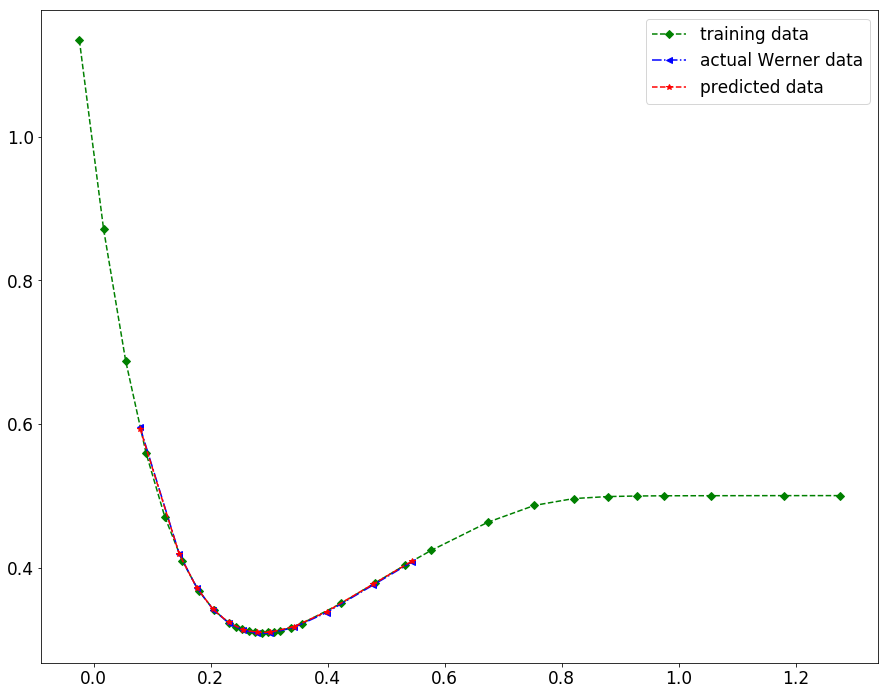

In [29]:
from scipy.interpolate import CubicSpline
cs = CubicSpline(R, V, bc_type='natural')
V_pred = cs(R)
rmse = RMSE(V, V_pred)
print("training RMSE =",rmse)
plt.subplots(figsize=(15, 12))

#predict Werner's V:
V_pred = cs(R_test)
rmse = RMSE(V_test, V_pred)
print("testing RMSE =",rmse)
plt.plot(np.log10(R), V, "g--D")
plt.plot(np.log10(R_test), V_test, "b-.<")
plt.plot(np.log10(R_test), V_pred, "r--*")
plt.legend(["training data","actual Werner data", "predicted data"])

test RMSE = 0.008246436812486388


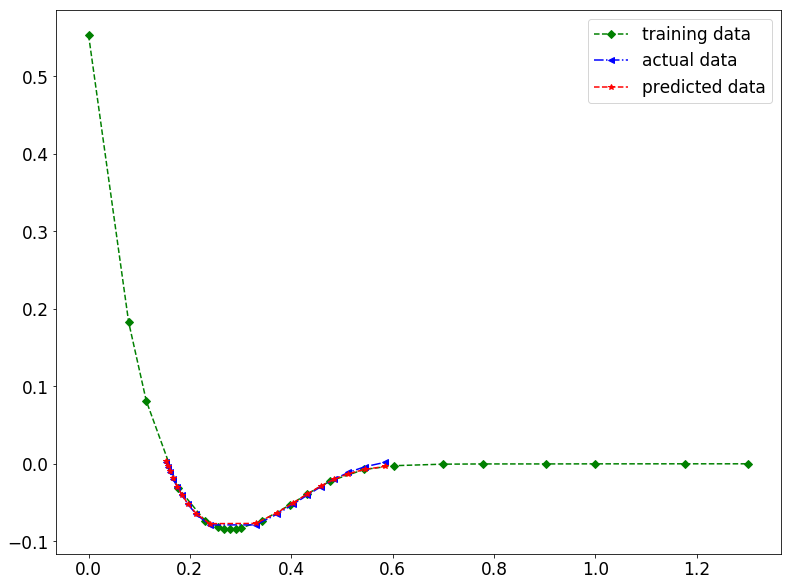

In [38]:
mol = "OH"
qidxs = query_many_vars_indices([mol, "$A^2\Sigma^+$"], ["mol", "state"], list_data)
newidxs = qidxs[1:3]
trainid = newidxs[0]; testid = newidxs[1]
R = list_data[trainid]["R"]; V = list_data[trainid]["V"] # training data
R_test = list_data[testid]["R"]; V_test = list_data[testid]["V"]# test data

cs = CubicSpline(R, V, bc_type='natural')
V_pred = cs(R_test)
print("test RMSE =", RMSE(V_test, V_pred))

plt.subplots(figsize=(13, 10))
plt.plot(np.log10(R), V, "g--D")
plt.plot(np.log10(R_test), V_test, "b-.<")
plt.plot(np.log10(R_test), V_pred, "r--*")
plt.legend(["training data","actual data", "predicted data"])

### Model 041021

C:\Users\beryl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


residual =  [5.20411638e-08 2.88852952e-07 2.23832959e-12 1.16990993e-07
 8.33236509e-08 2.72636713e-09 2.47383542e-08 5.86630304e-08
 3.99962262e-08 2.16406486e-08 6.86558492e-09 2.25378625e-10
 2.47966702e-09 1.07741741e-08 2.03869582e-08 2.65419105e-08
 2.71759022e-08 1.16017082e-08 9.53013314e-11 1.86873305e-07
 5.76974363e-10 1.77703940e-07 9.47627782e-08 4.61030554e-09
 5.81058765e-10 9.23942411e-11 4.00805181e-12 2.05885648e-12
 1.31470378e-12 8.16991357e-12 7.43960681e-11 7.45030465e-10]
RMSE =  0.00019852250689328925

`xtol` termination condition is satisfied.
Function evaluations 232, initial cost 1.0932e+34, final cost 5.0823e-05, first-order optimality 1.21e+17.
`xtol` termination condition is satisfied.
RMSE =  0.0017822604871882701

RMSE = 0.0

`ftol` termination condition is satisfied.
Function evaluations 292, initial cost 2.0771e+10, final cost 1.1915e-01, first-order optimality 2.39e-02.
`ftol` termination condition is satisfied.
RMSE =  0.08629657007673698
`ftol` ter

Text(0.5, 1.0, 'nonlinear diatomic with least squares, degree = 16; Z=1')

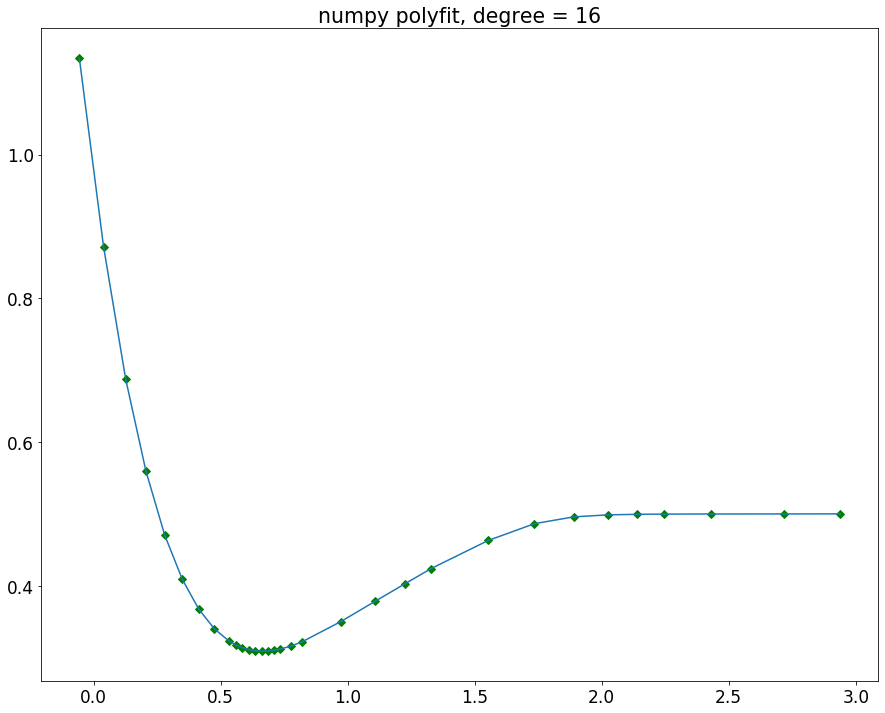

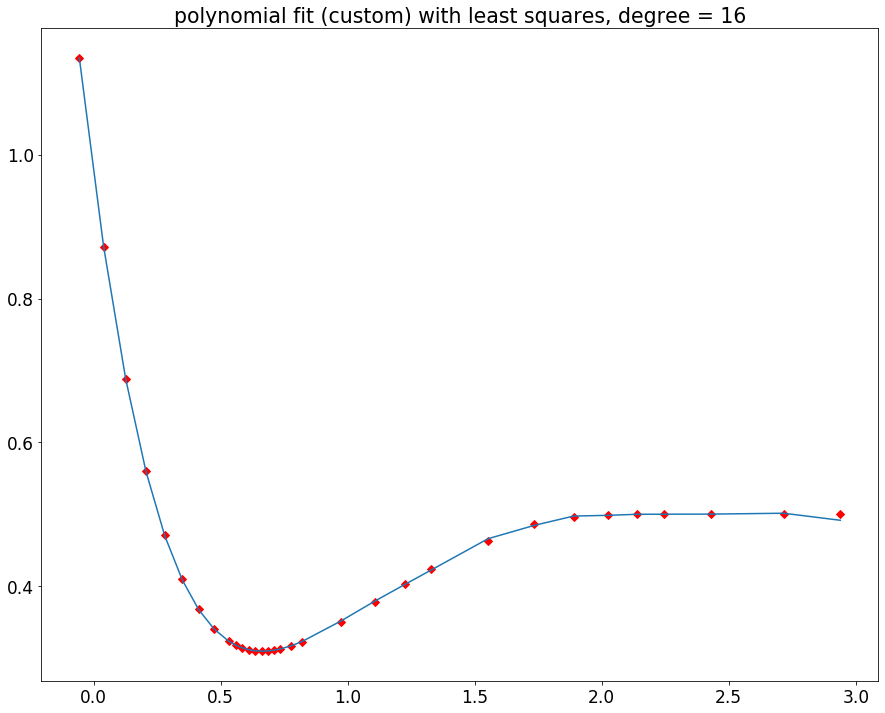

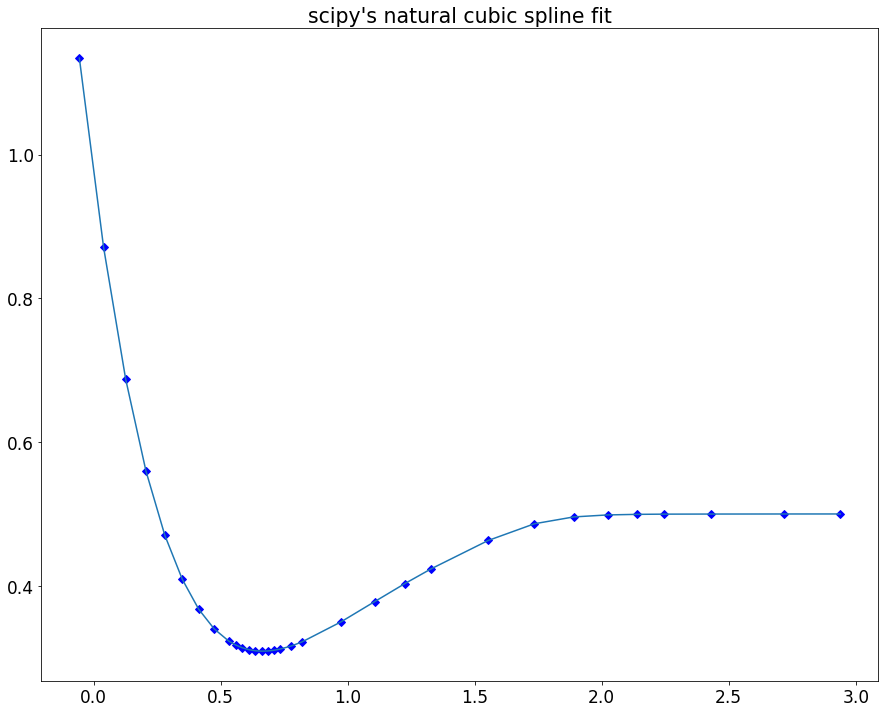

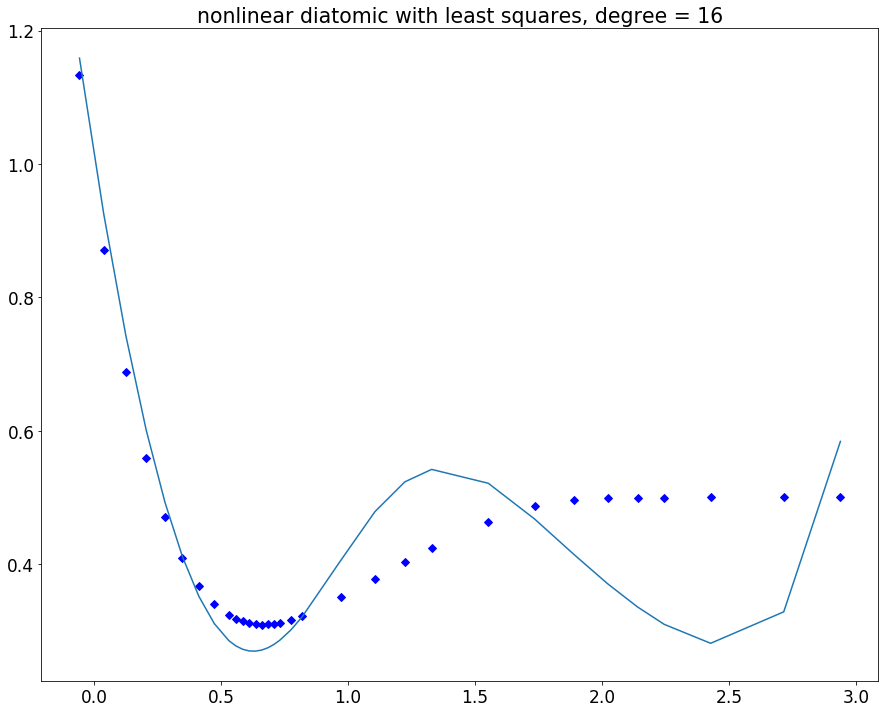

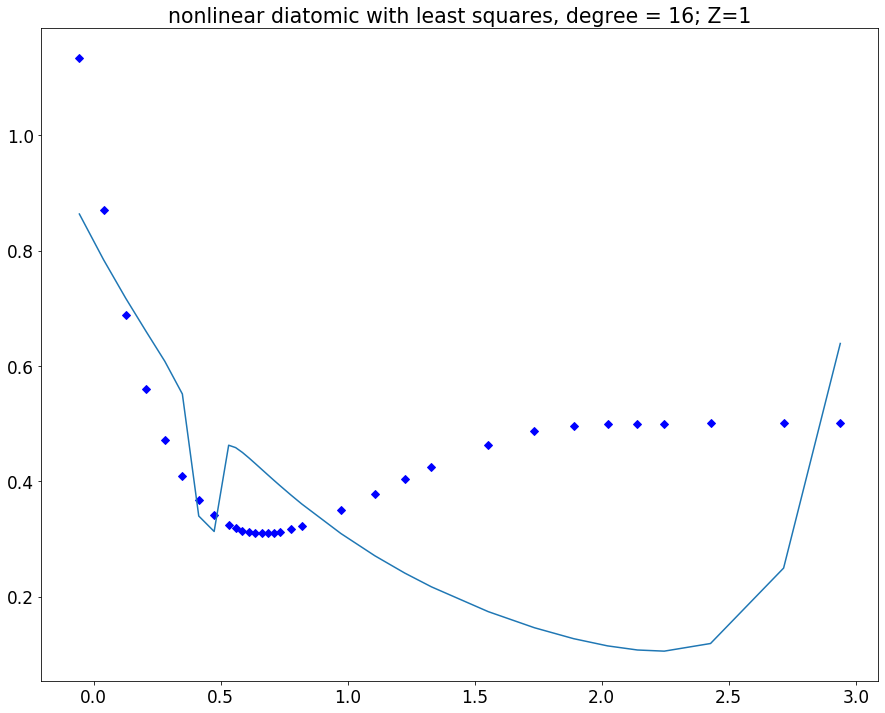

In [56]:
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 17})

mol = "OH+"
qidxs = query_one_var_indices(mol, "mol", list_data)
#train and test on idx 4:
idx = 4
R = list_data[qidxs[idx]]["R"]
V = list_data[qidxs[idx]]["V"]
M = 16
#C0 = np.random.uniform(0, 1, size=(M)) #to avoid division by 0
C0 = np.zeros(M) + 1e-2
Z = (1, 8) #atomic number of atom_1 and atom_2 (permutationally symmetric)
poly_par = {"M":M, "morse":False}


C = np.polyfit(R, V, M) #automatic fit by numpy
e = f_poly_res(C[::-1], f_monomial_diatomic_pot, R, V, poly_par)
print("residual = ",e) #the residual function is correct
#p = np.poly1d(C)
#V_pred = p(R)
V_pred = [f_monomial_diatomic_pot(r, C[::-1], poly_par["morse"]) for r in R] #doublecheck the residual function
print("RMSE = ",RMSE(V_pred, V)) #the polynomial function is correct
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "gD")
plt.plot(np.log(R), V_pred)
plt.title("numpy polyfit, degree = "+str(M))
print()

#using polynomial fit but manual leastsquares:
#C0 = C[::-1] #look at the correct C
res = least_squares(f_poly_res2, C0, args=(f_monomial_diatomic_pot, R, V, poly_par), verbose=1, method="lm")
print(res.message)
V_pred = np.array([f_monomial_diatomic_pot(r, res.x, poly_par["morse"]) for r in R])
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "rD")
plt.plot(np.log(R), V_pred)
plt.title("polynomial fit (custom) with least squares, degree = "+str(M))
print()

#cubic spline:
cs = CubicSpline(R, V, bc_type='natural')
V_pred = cs(R)
print("RMSE =", RMSE(V, V_pred))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("scipy's natural cubic spline fit")
print()

#using the 2nd proposed method:
#soln = dfbgn.solve(f_obj_diatomic_pot_lr, C0, args=(f_diatomic_pot_lr, V, R, Z))
#print(soln) #dfbgn fails

res = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_pot_lr, V, R, Z), verbose=1, method="lm")
print(res.message)
V_pred = [f_diatomic_pot_lr(res.x, r, Z) for r in R]
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("nonlinear diatomic with least squares, degree = "+str(M))


Z = (1,1) #reduce the effect of nuclear charge:
res = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_pot_lr, V, R, Z), verbose=1, method="lm")
print(res.message)
V_pred = [f_diatomic_pot_lr(res.x, r, Z) for r in R]
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("nonlinear diatomic with least squares, degree = "+str(M)+"; Z=1")
